In [27]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple
from time import time

# 1. Index by boolean

In [3]:
a = np.arange(10)
print('a: ', a)

a:  [0 1 2 3 4 5 6 7 8 9]


## Take elements of `a` that satisfy a condition:
```
a[i] > 5
```
### Sequential

In [4]:
out = []
for element in a:
    if element > 5:
        out.append(element)

print('out: ', out)

out:  [6, 7, 8, 9]


### Vectorized

In [5]:
out = a[a > 5]
print('out: ', out)

out:  [6 7 8 9]


### refer to `apply_se3.py` for a more elaborated example

# 2. Meshgrid

for defining a surface -> to visualize loss function z = f(x, y)

![alt text](1xeW8.png "A Grid")

## Sequential

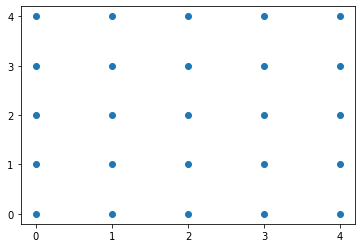

In [12]:
xs = np.arange(5)
ys = np.arange(5)

mat_x, mat_y = list(), list()

for y in xs:
    for x in ys:
        mat_x.append(x)
        mat_y.append(y)

fig, ax = plt.subplots()
_ = ax.scatter(mat_x, mat_y)
_ = ax.set_xticks(xs)
_ = ax.set_yticks(ys)

## Vectorized 

in matrix coordinate system

 ------------------------> x-axis (dim=1, column)\
  |\
  |\
  |\
v\
y-axis (dim=0, row)

In [15]:
yy, xx = np.meshgrid(ys, xs, indexing='ij')
# Note: use indexing='ij' to signify that we are using matrix coordinate
print('yy:\n', yy)
print('xx:\n', xx)

yy:
 [[0 0 0 0 0]
 [1 1 1 1 1]
 [2 2 2 2 2]
 [3 3 3 3 3]
 [4 4 4 4 4]]
xx:
 [[0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]
 [0 1 2 3 4]]


all_x:
 [0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4 0 1 2 3 4]


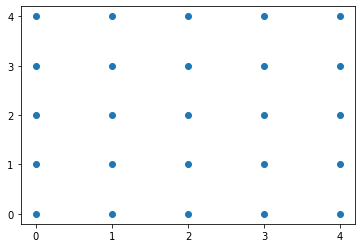

In [17]:
all_x = xx.reshape(-1)
print('all_x:\n', all_x)
all_y = yy.reshape(-1)
fig, ax = plt.subplots()
_ = ax.scatter(all_x, all_y)
_ = ax.set_xticks(xs)
_ = ax.set_yticks(ys)

## Make a surface

Normal distribution $\mathcal{N} \left(\mu, ~\Sigma \right)$

pdf = $\left(2 \pi \right)^{-1} \det \left(\Sigma \right)^{-1/2} \exp\left(-\frac{1}{2}\left(\mathbf{x} - \mu\right)^T \Sigma^{-1} \left(\mathbf{x} - \mu\right) \right)$

with\
$\mu = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$

$\Sigma = \begin{bmatrix}
1 & 3/5 \\
3/5 & 2
\end{bmatrix}$

In [41]:
sigma = np.array([
    [1., 0.6],
    [0.6, 2.]
])

mu = np.zeros(2)

scale = 1.0 / (np.sqrt(np.linalg.det(sigma)) * 2.0 * np.pi)

step = 0.1
xs = np.arange(-5, 5, step=step)
ys = np.arange(-5, 5, step=step)
yy, xx = np.meshgrid(ys, xs, indexing='ij')

In [42]:
# xx: (M, N)
# yy: (M, N)
# merge_xx_yy -> (M, N, 2) - (2) := x, y !!! not y, x
grid_xy = np.concatenate([xx[..., np.newaxis], yy[..., np.newaxis]], axis=-1)

print('grid_xy @ location (x=0, y=1): ', grid_xy[1, 0])

grid_xy @ location (x=0, y=1):  [-5.  -4.9]


## Batch matrix multiplication using np.einsum

In [43]:
pre_exp = -0.5 * np.einsum('mni, ij, mnj -> mn', grid_xy, np.linalg.inv(sigma), grid_xy)
print('pre_exp.shape: ', pre_exp.shape)

pdf = scale * np.exp(pre_exp)
print('pdf.shape: ', pdf.shape)

pre_exp.shape:  (100, 100)
pdf.shape:  (100, 100)


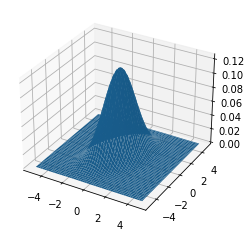

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
_ = ax.plot_surface(xx, yy, pdf)

# 3. Broadcasting

## A simple approach to multi-object tracking using Bipartite Matching

Given a set of prediction $\mathcal{P} = \{\mathbf{p}_i | i = 1, ..., T\}$, and a set of detection $\mathcal{D} = \{\mathbf{d}_j | j = 1, ..., D\}$, 
find the corresponding detection of each prediction 

Condition: \
i. two prediction can't have the same detection \
ii. a valid match $\left(\mathbf{p}_i, \mathbf{d}_j\right)$ must have distance < a threshold: $|| \mathbf{p}_i - \mathbf{d}_j ||_{2} < \tau$

## Greedy Association
1. for each $\mathbf{p}_i$ compute its distance to every $\mathbf{d}_j$, then store the distance in an array $\mathbf{C}$
2. sort $\mathbf{C}$ in ascending order

3. matched_prediction = {}, matched_detection = {}, matches: List[Tuple[int, int]] = []

4. for $c_h$ in $\mathbf{C}$:
5.      find the index i and j of the prediction and the detection that produce c_h
6.      if i & j haven't been seen before:
7.          add i to matched_prediction
8.          add j to matched_detection
9.          add (i, j) to matches

10. return matches
11. [optinal] return unmatched prediction and unmatched detection

## Implementation

In [24]:
def greedy(pred: np.ndarray, det: np.ndarray, threshold: float, mode='vectorized') -> List[Tuple[int]]:
    """
    Greedy association for solving pipartite matching

    Args:
        pred: (T, 3) - x, y, z
        det: (M, 3) - x, y, z
        threshold: valid matches must have distance < threshold

    Returns:
        matches: List[(index of pred, index of det)] 
    """
    if mode == 'vectorized':
        cost = pred[:, np.newaxis] - det[np.newaxis]  # (T, 1, 3) - (1, D, 3) -> (T, D, 3)
        cost = np.linalg.norm(cost, axis=2)  # (T, D)
        # flatten cost
        cost = cost.reshape(-1)  # (T * D,)
    else:
        # sequential
        cost = list()
        for p in pred:
            for d in det:
                cost.append(np.linalg.norm(p - d))
    
    # sort
    sorted_flatten_indices = np.argsort(cost)

    # find match
    matched_pred, matched_det = set(), set()
    matches = list()
    num_det = det.shape[0]
    for cost_index in sorted_flatten_indices:
        # early stopping condition
        if cost[cost_index] > threshold:
            break

        # compute pred's index & det's index from cost_index
        # cost_index = pred_idx * num_det + det_idx
        pred_idx = cost_index // num_det
        det_idx = cost_index % num_det
        if pred_idx in matched_pred or det_idx in matched_det:
            continue
        else:
            if cost[cost_index] < threshold:
                matched_pred.add(pred_idx)
                matched_det.add(det_idx)
                matches.append((pred_idx, det_idx))

    return matches


## Let's try it out
Prediction\
![alt text](pred.png "Title")

$\mathbf{P} = \begin{bmatrix}
    \color{red} 144.6 & \color{red} 78.8 \\
    \color{blue} 194.6 & \color{blue} 67.2 \\
    214.8 &  108.6 \\
\end{bmatrix}$

Detection\
![alt text](det.png "Title")

$\mathbf{D} = \begin{bmatrix}
    147.9 & 84.5 \\
    189.2 & 76.1 \\
    210.7 & 103.8 \\
    313.1 & 122.0 \\
\end{bmatrix}$


Note: pred & det are indexed from left to right (& top to bottom)

In [18]:
pred = np.array([
    [144.6, 78.8],
    [194.6, 67.2],
    [214.8, 108.6]
])

det = np.array([
    [147.9, 84.5],
    [189.2, 76.1],
    [210.7, 103.8],
    [313.1, 122.0]
])

In [26]:
matches = greedy(pred, det, threshold=15.)
print('pred \t\t\t det \t\t\t distance')
for (i, j) in matches:
    print(f'{pred[i]} \t\t {det[j]} \t\t {np.linalg.norm(pred[i] - det[j])}')

pred 			 det 			 distance
[214.8 108.6] 		 [210.7 103.8] 		 6.3126856408346645
[144.6  78.8] 		 [147.9  84.5] 		 6.586349520030053
[194.6  67.2] 		 [189.2  76.1] 		 10.410091258005375


## Execution Time comparison

In [28]:
tic = time()
matches = greedy(pred, det, threshold=15., mode='sequential')
tac = time()
print(f'sequential cost: {tac - tic} seconds')

tic = time()
matches = greedy(pred, det, threshold=15., mode='vectorized')
tac = time()
print(f'vectorized cost: {tac - tic} seconds')

sequential cost: 0.0005476474761962891 seconds
vectorized cost: 0.00023674964904785156 seconds


In [ ]:
times_seq, times_vec = list(), list()
sizes = [10, 100, 1000, 10000]
for n in sizes:
    pred = np.random.rand(n, 3)
    det = np.random.rand(n, 3)
    
    tic = time()
    _ = greedy(pred, det, threshold=15., mode='sequential')
    tac = time()
    times_seq.append(tac - tic)

    tic = time()
    _ = greedy(pred, det, threshold=15., mode='vectorized')
    tac = time()
    times_vec.append(tac - tic)

fig, ax = plt.subplots()
ax.plot(sizes, times_seq, label='seq')
ax.plot(sizes, times_vec, label='vec')